In [1]:
import os
import time
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import pyswarms as ps
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

globalpath = "../DataCleaning/A - CSV par bâtiment/"
globalpath2 = "../DataCleaning/"
###############################################################################
# 1) Chargement et préparation des données
###############################################################################
def load_and_prepare_data(csv_path, production_column='production', window_size=24):
    """
    Charge le fichier CSV, scale les données, crée des fenêtres (x,y),
    et renvoie les splits (x_train, y_train, x_test, y_test, x_val, y_val).
    """
    df = pd.read_csv(csv_path)


    # Mise à l'échelle
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(df.values)
    # ➕ Scaler dédié uniquement à la colonne cible
    target_scaler = MinMaxScaler()
    target_scaler.fit(df[[production_column]])
    # Retrouver l'index de la colonne cible
    target_col_idx = df.columns.get_loc(production_column)
    
    # Création des fenêtres
    x, y = [], []
    for i in range(window_size, len(data_scaled)):
        x.append(data_scaled[i-window_size:i])
        y.append(data_scaled[i, target_col_idx])
    x, y = np.array(x), np.array(y)
    
    # Split train/test/val
    # Ici, 80% train, 10% test, 10% val (à adapter si besoin)
    train_split_index = int(0.8 * len(x))
    test_split_index  = int(0.9 * len(x))
    
    x_train, y_train = x[:train_split_index], y[:train_split_index]
    x_test,  y_test  = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
    x_val,   y_val   = x[test_split_index:], y[test_split_index:]
    
    # Adapter la forme pour ConvLSTM1D (on insère un channel dimension)
    x_train_conv = np.expand_dims(x_train, axis=2)
    x_test_conv  = np.expand_dims(x_test, axis=2)
    x_val_conv   = np.expand_dims(x_val, axis=2)
    
    return (x_train_conv, y_train,
            x_test_conv,  y_test,
            x_val_conv,   y_val,
            df,target_scaler  )


###############################################################################
# 2) Baseline (e-base) : un simple entraînement avec des hyperparamètres fixes
###############################################################################
def build_baseline_model(input_shape):
    """
    Construit un modèle ConvLSTM basique avec des hyperparamètres
    fixes (par ex. 64 filtres, 64 neurones denses, lr=0.001).
    """
    model = tf.keras.Sequential([
        ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh',
                   return_sequences=True, input_shape=input_shape),
        ConvLSTM1D(filters=64, kernel_size=(1,), activation='tanh', return_sequences=False),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dense(1, activation="linear")
    ], name="baseline_conv_lstm")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss="mae", optimizer=optimizer)
    return model


###############################################################################
# 3) Modèle paramétrable pour PSO
###############################################################################
def build_convlstm_model(lr, filters1, filters2, dense_units, input_shape):
    """
    Construit et compile un modèle ConvLSTM1D avec hyperparamètres modulables.
    """
    model = tf.keras.Sequential([
        ConvLSTM1D(filters=int(filters1), kernel_size=(1,), activation='tanh',
                   return_sequences=True, input_shape=input_shape),
        ConvLSTM1D(filters=int(filters2), kernel_size=(1,), activation='tanh', return_sequences=False),
        Flatten(),
        Dense(units=int(dense_units), activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation="linear")
    ], name="model_conv_lstm")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="mae", optimizer=optimizer)
    return model

def plot_and_save_analysis(y_test, y_pred, save_dir, dataset_name,target_scaler):
    os.makedirs(save_dir, exist_ok=True)
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # 1. Scatter plot (prédictions vs réel)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Idéal (y = ŷ)")
    plt.xlabel("Valeurs réelles (y)")
    plt.ylabel("Prédictions (ŷ)")
    plt.title(f"{dataset_name} - Prédictions vs Réel")
    plt.legend()
    plt.grid(True)
    scatter_path = os.path.join(save_dir, f"{dataset_name}_scatter.png")
    plt.savefig(scatter_path)
    plt.close()

    # 2. Histogramme des erreurs
    errors = y_test - y_pred
    plt.figure(figsize=(8, 4))
    plt.hist(errors, bins=20, color='orange', edgecolor='black')
    plt.title(f"{dataset_name} - Distribution des erreurs")
    plt.xlabel("Erreur (y - ŷ)")
    plt.ylabel("Fréquence")
    plt.grid(True)
    hist_path = os.path.join(save_dir, f"{dataset_name}_hist.png")
    plt.savefig(hist_path)
    plt.close()

    # 3. Courbe temporelle
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label="Valeurs réelles", linewidth=2)
    plt.plot(y_pred, '--', label="Prédictions")
    plt.title(f"{dataset_name} - Évolution temporelle")
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    plt.legend()
    plt.grid(True)
    curve_path = os.path.join(save_dir, f"{dataset_name}_courbe.png")
    plt.savefig(curve_path)
    plt.close()

    return scatter_path, hist_path, curve_path



###############################################################################
# 4) Entraînement + évaluation (MAE, MSE, R²) + temps d'exécution
###############################################################################
def train_and_evaluate_model(model, x_train, y_train, x_val, y_val,
                             epochs=50, batch_size=512, verbose=0, dataset_name="dataset"):
    """
    Entraîne le modèle, mesure le temps d'entraînement, et renvoie l'historique.
    """
    stop_early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    start_time = time.time()
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        callbacks=[stop_early])
    training_time = time.time() - start_time
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{dataset_name}Courbe d'apprentissage (loss)")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_plots_loss_curve_{model.name}.png")
    plt.close()
    
    return history, training_time


def inference_time_and_metrics(model, x_test, y_test):
    """
    Calcule le temps d'inférence, puis renvoie MAE, MSE, R².
    """
    start_time = time.time()
    preds = model.predict(x_test)
    inference_time = time.time() - start_time
    
    preds = preds.reshape(-1)
    y_test = y_test.reshape(-1)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2  = r2_score(y_test, preds)
    
    return mae, mse, r2, inference_time


###############################################################################
# 5) Fonction objectif pour OPTUNA
###############################################################################

def objective(trial, input_shape, x_train, y_train, x_val, y_val):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)  # nouvelle syntaxe recommandée
    f1 = trial.suggest_int('filters1', 32, 128)
    f2 = trial.suggest_int('filters2', 32, 128)
    dense = trial.suggest_int('dense_units', 32, 128)

    model = Sequential([
        ConvLSTM1D(filters=f1, kernel_size=(1,), activation='tanh', return_sequences=True, input_shape=input_shape),
        ConvLSTM1D(filters=f2, kernel_size=(1,), activation='tanh', return_sequences=False),
        Flatten(),
        Dense(units=dense, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=lr), loss='mae')

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=256,
        verbose=0
    )

    return min(history.history['val_loss'])



###############################################################################
# 6) Boucle sur les datasets et compilation des résultats
###############################################################################
def run_experiments_on_datasets(
    dataset_paths,
    production_column='production',
    window_size=24,
    epochs_baseline=50,
    epochs_optimized=50
):
    """
    - Pour chaque dataset :
        1) Prépare les données
        2) Entraîne le modèle baseline (e-base) et mesure ses métriques
        3) Lance l'optimisation PSO
        4) Entraîne le modèle avec les hyperparams optimisés
        5) Mesure les métriques et temps
        6) Stocke les résultats dans un DataFrame
    """
    results = []
    
    for csv_path in dataset_paths:
        dataset_name = os.path.basename(csv_path).replace('.csv','')
        print(f"\n=== Dataset: {dataset_name} ===")
        
        # 1) Chargement et préparation
        x_train, y_train, x_test, y_test, x_val, y_val, df,target_scaler  = load_and_prepare_data(
            csv_path,
            production_column=production_column,
            window_size=window_size
        )
        input_shape = x_train.shape[1:]
        
        # 2) Modèle baseline
        baseline_model = build_baseline_model(input_shape)
        history_base, t_train_base = train_and_evaluate_model(
            baseline_model, x_train, y_train, x_val, y_val,
            epochs=epochs_baseline, batch_size=512, verbose=0,dataset_name=dataset_name
        )
        mae_base, mse_base, r2_base, t_infer_base = inference_time_and_metrics(baseline_model, x_test, y_test)
        # 3) Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, input_shape, x_train, y_train, x_val, y_val), n_trials=20)
        print("Best hyperparameters:", study.best_params)

        
        # 4) Entraîner le modèle avec les hyperparamètres optimisés
        best_params = study.best_params
        lr_opt        = best_params['lr']
        filters1_opt  = best_params['filters1']
        filters2_opt  = best_params['filters2']
        dense_opt     = best_params['dense_units']

        # Ajoute ce format dans le dictionnaire des résultats :
        param_opt_string = f"lr={lr_opt:.5f}, f1={filters1_opt}, f2={filters2_opt}, dense={dense_opt}"
        best_model = build_convlstm_model(lr_opt, filters1_opt, filters2_opt, dense_opt, input_shape)
        history_opt, t_train_opt = train_and_evaluate_model(
            best_model, x_train, y_train, x_val, y_val,
            epochs=epochs_optimized, batch_size=512, verbose=0,dataset_name=dataset_name
        )
        
        # 5) Évaluation finale
        mae_opt, mse_opt, r2_opt, t_infer_opt = inference_time_and_metrics(best_model, x_test, y_test)
        
        scatter_path, hist_path, curve_path = plot_and_save_analysis(
            y_test=y_test, 
            y_pred=best_model.predict(x_test).flatten(), 
            save_dir="plots", 
            dataset_name=dataset_name,
            target_scaler=target_scaler
        )
        
        # 6) Stockage des résultats dans un dictionnaire
        result_dict = {
            "Dataset": dataset_name,
            
            # E-base
            "MAE e-base": mae_base,
            "MSE e-base": mse_base,
            "R2 e-base":  r2_base,
            "T(entrainement-e-base)[s]": t_train_base,
            
            
            #Optuna
            "Optuna best R2": r2_opt,
            "Paramètres optimisés": f"lr={lr_opt:.5f}, f1={filters1_opt}, f2={filters2_opt}, dense={dense_opt}",
            
            # Entraînement optimisé
            "T(entrainement-optimisé)[s]": t_train_opt,
            "MAE optimisé": mae_opt,
            "MSE optimisé": mse_opt,
            "R2 optimisé": r2_opt,
            "Graph_scatter": scatter_path,
            "Graph_hist": hist_path,
            "Graph_courbe": curve_path,
            
            # Inférence
            "T(evaluation-inference)[s]": t_infer_opt,
            
            # Nombre d'époques
            "Nombre d'époques e-base": epochs_baseline,
            "Nombre d'époques optimisé": epochs_optimized
        }
        
        results.append(result_dict)
    
    # Conversion en DataFrame
    df_results = pd.DataFrame(results)
    return df_results


###############################################################################
# 7) Lancement final (exemple)
###############################################################################
if __name__ == "__main__":
    # Liste des chemins vers vos CSV
    dataset_paths = [
        globalpath2+"scaled_dataset.csv",
    ]
    
    # Paramètres globaux (à adapter)
    production_column = 'production'
    window_size = 24      # taille des fenêtres
    epochs_baseline = 50  # nombre d'époques pour la baseline
    epochs_optimized = 100 # nombre d'époques pour le modèle optimisé
    
    # Lancement des expériences
    df_results = run_experiments_on_datasets(
        dataset_paths,
        production_column=production_column,
        window_size=window_size,
        epochs_baseline=epochs_baseline,
        epochs_optimized=epochs_optimized
    )
    
    # Affichage des résultats finaux
    print("\n=========== RÉSULTATS FINAUX ===========")
    print(df_results)
    # Sauvegarde éventuellement en CSV
    df_results.to_csv("resume_resultatsOptuna.csv", index=False)


c:\Users\sylva\Documents\CESI\A4\IR\GIT\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sylva\Documents\CESI\A4\IR\GIT\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



=== Dataset: scaled_dataset ===
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


[I 2025-06-10 13:35:08,840] A new study created in memory with name: no-name-6ccbb042-e6cd-4bab-b167-b0cab2ef14f1
c:\Users\sylva\Documents\CESI\A4\IR\GIT\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-10 13:35:40,845] Trial 0 finished with value: 0.02337801456451416 and parameters: {'lr': 0.0003815406039447927, 'filters1': 52, 'filters2': 95, 'dense_units': 65}. Best is trial 0 with value: 0.02337801456451416.
[I 2025-06-10 13:36:12,534] Trial 1 finished with value: 0.02366761676967144 and parameters: {'lr': 0.0005015502111783601, 'filters1': 58, 'filters2': 94, 'dense_units': 52}. Best is trial 0 with value: 0.02337801456451416.
[I 2025-06-10 13:36:57,812] Trial 2 finished with value: 0.025180870667099953 and parameters: {'lr': 0.00012279797846034127, 'fil

Best hyperparameters: {'lr': 0.0005712570389221931, 'filters1': 100, 'filters2': 67, 'dense_units': 119}
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

=========== RÉSULTATS FINAUX ===========
          Dataset  MAE e-base  MSE e-base  R2 e-base  \
0  scaled_dataset    0.017056    0.000566   0.495293   

   T(entrainement-e-base)[s]  Optuna best R2  \
0                  59.991621        0.559887   

                   Paramètres optimisés  T(entrainement-optimisé)[s]  \
0  lr=0.00057, f1=100, f2=67, dense=119                    193.08858   

   MAE optimisé  MSE optimisé  R2 optimisé                     Graph_scatter  \
0      0.014969      0.000494     0.559887  plots\scaled_dataset_scatter.png   

                      Graph_hist                     Graph_courbe  \
0  plots\scaled_dataset_hist.png  plots\scaled_dataset_courbe.png   

   T(evaluation-inference)[s]  Nombre d'époques e-base  \
0                    0.958457                       50   

=

c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


[I 2025-06-10 12:07:56,834] A new study created in memory with name: no-name-92ab9251-5ed9-44b2-994b-db5fcf508606
c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-10 12:08:28,746] Trial 0 finished with value: 0.24130845069885254 and parameters: {'lr': 0.00033281206812891314, 'filters1': 121, 'filters2': 34, 'dense_units': 52}. Best is trial 0 with value: 0.24130845069885254.
[I 2025-06-10 12:09:03,195] Trial 1 finished with value: 0.24826930463314056 and parameters: {'lr': 0.0008846897810780857, 'filters1': 42, 'filters2': 79, 'dense_units': 70}. Best is trial 0 with value: 0.24130845069885254.
[I 2025-06-10 12:09:55,704] Trial 2 finished with value: 0.2570447325706482 and parameters: {'lr': 0.0003587933638272461, 'filters1': 51

Best hyperparameters: {'lr': 0.002714061828884007, 'filters1': 78, 'filters2': 39, 'dense_units': 71}
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

=== Dataset: batiment_9 ===


c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step


[I 2025-06-10 12:18:38,689] A new study created in memory with name: no-name-ba803ea0-8632-4de7-9790-20d0e7aed73a
c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-06-10 12:19:10,849] Trial 0 finished with value: 0.19623850286006927 and parameters: {'lr': 0.007012028651605841, 'filters1': 42, 'filters2': 59, 'dense_units': 79}. Best is trial 0 with value: 0.19623850286006927.
[I 2025-06-10 12:19:44,815] Trial 1 finished with value: 0.19906818866729736 and parameters: {'lr': 0.0016794048954776675, 'filters1': 76, 'filters2': 43, 'dense_units': 128}. Best is trial 0 with value: 0.19623850286006927.
[I 2025-06-10 12:20:21,689] Trial 2 finished with value: 0.2189042866230011 and parameters: {'lr': 0.00031070612930219965, 'filters1': 85,

Best hyperparameters: {'lr': 0.0005518691388397113, 'filters1': 124, 'filters2': 79, 'dense_units': 117}
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step

=========== RÉSULTATS FINAUX ===========
      Dataset  MAE e-base  MSE e-base  R2 e-base  T(entrainement-e-base)[s]  \
0  batiment_1    0.187451    0.061728  -0.030566                  24.550864   
1  batiment_2    0.140695    0.031628  -0.296603                  44.092397   
2  batiment_3    0.150570    0.043247   0.210770                  20.044827   
3  batiment_4    0.182121    0.074563   0.233209                  32.909906   
4  batiment_5    0.130334    0.026719   0.146380                  53.053791   
5  batiment_6    0.225067    0.072628   0.015912                  33.002616   
6  batiment_7    0.181426    0.038318  -0.271926                  21.999698   
7  batiment_8    0.186928    0.058311   0.057714                  36.225128   
8  batiment_9    0.193191    0.059252   0.062802                

Epoch 1/700


c:\Users\Natha\anaconda3\envs\IR_pv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1045 - val_loss: 0.0995
Epoch 2/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0913 - val_loss: 0.1074
Epoch 3/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0888 - val_loss: 0.0840
Epoch 4/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0851 - val_loss: 0.0912
Epoch 5/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0847 - val_loss: 0.0818
Epoch 6/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0846 - val_loss: 0.0853
Epoch 7/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0838 - val_loss: 0.0812
Epoch 8/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0813 - val_loss: 0.0844
Epoch 9/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0837 - val_loss: 0.0804
Epoch 10/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0842 - val_loss: 0.0919
Epoch 11/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0822 - val_loss: 0.0835
Epoch 12/700
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 1

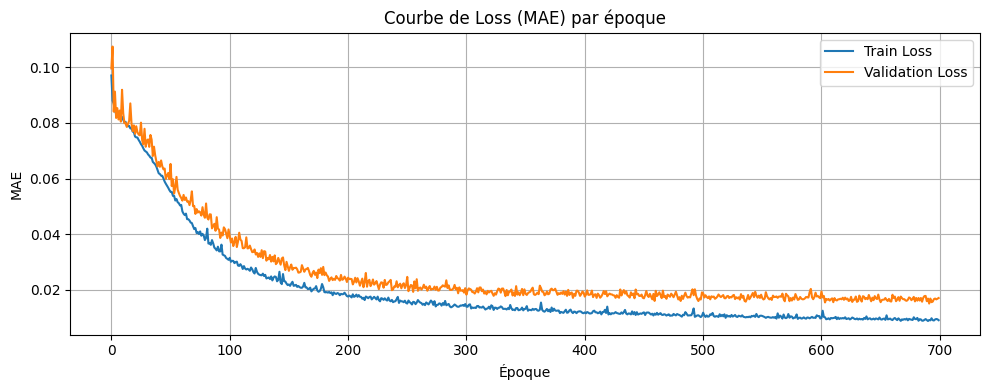

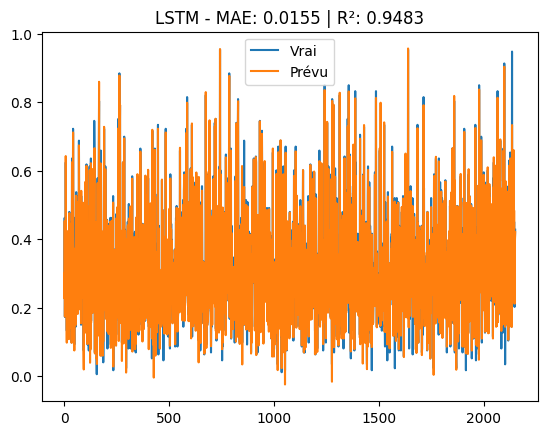

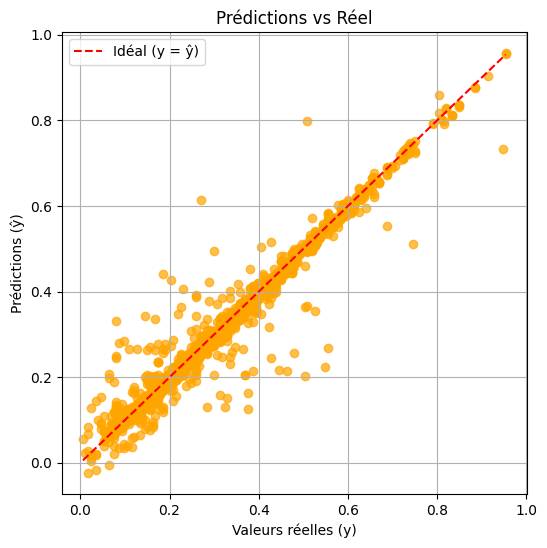

In [33]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === 1. Chargement des données ===
df = pd.read_csv(globalpath+"scaled_dataset_clean.csv")  # Remplace par ton CSV réel

# === 2. Normalisation ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
X_scaled = scaled_data[:, :-1]
y_scaled = scaled_data[:, -1]

# === 3. Création des séquences temporelles ===
def create_sequences(X, y, window_size=7):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

window_size = 21
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

# === 4. Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# === 5. Définition du modèle LSTM ===
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer=Adam(0.001), loss='mae')

# === 6. Entraînement ===
history = model.fit(X_train, y_train, epochs=700, batch_size=32, validation_split=0.1, verbose=1)

# === 7. Évaluation ===
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# === 8. Affichage ===


plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Courbe de Loss (MAE) par époque')
plt.xlabel('Époque')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.plot(y_test, label="Vrai")
plt.plot(y_pred, label="Prévu")
plt.legend()
plt.title(f"LSTM - MAE: {mae:.4f} | R²: {r2:.4f}")
plt.show()


# 1. Scatter plot (prédictions vs réel)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Idéal (y = ŷ)")
plt.xlabel("Valeurs réelles (y)")
plt.ylabel("Prédictions (ŷ)")
plt.title("Prédictions vs Réel")
plt.legend()
plt.grid(True)
plt.show()